# Simple Neural Network model to perform classification of handwritten digits

* ### Import all required modules

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import keras
from keras.utils import np_utils
from keras.datasets import mnist
from keras import backend
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

import coremltools

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

* ### Set random state which is about to be used in a notebook and some numpy, matpotlib settings

In [3]:
random_state = 42
np.random.seed(random_state)
plt.figure(figsize=(80,80))

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

* ### Let's load MNIST data and split it into train and test

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

* ### Let's look at the data we are going to use for training

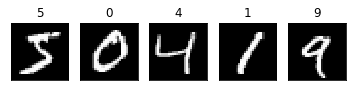

In [5]:
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
    plt.title(y_train[i])
    plt.xticks([])
    plt.yticks([])

* ### Let's process our data to prepare it for training and validation as well

In [6]:
image_rows, image_cols = 28, 28

if backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, image_rows, image_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, image_rows, image_cols)
    input_shape = (1, image_rows, image_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], image_rows, image_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], image_rows, image_cols, 1)
    input_shape = (image_rows, image_cols, 1)

X_train = X_train.astype('float32') / 5
X_test = X_test.astype('float32') / 5

* ### Encode Categorical Features with Ohe Hot Encoding

In [7]:
num_categories = 10
y_train = np_utils.to_categorical(y_train, num_categories)
y_test = np_utils.to_categorical(y_test, num_categories)

* ### Declare, tune and compile the Neural Network Architecture (VGG-like ConvNet)

In [10]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_categories, activation='softmax'))

In [11]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

* ### Perform training on the data

In [12]:
batch_size = 128
num_epoch = 8
model.fit(X_train, 
          y_train,
          batch_size=batch_size,
          epochs=num_epoch,
          validation_data=(X_test, y_test))

Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Train on 60000 samples, validate on 10000 samples
Epoch 1/8
60000/60000 [==============================] - 100s 2ms/step - loss: 0.3014 - acc: 0.9098 - val_loss: 0.0482 - val_acc: 0.9843
Epoch 2/8
60000/60000 [==============================] - 99s 2ms/step - loss: 0.0848 - acc: 0.9742 - val_loss: 0.0291 - val_acc: 0.9907
Epoch 3/8
60000/60000 [==============================] - 99s 2ms/step - loss: 0.0607 - acc: 0.9808 - val_loss: 0.0250 - val_acc: 0.9918
Epoch 4/8
60000/60000 [==============================] - 98s 2ms/step - loss: 0.0509 - acc: 0.9848 - val_loss: 0.0252 - val_acc: 0.9916
Epoch 5/8
60000/60000 [==============================] - 99s 2ms/step - loss: 0.0418 - acc: 0.9872 - val_loss: 0.0213 - val_acc: 0.9929
Epoch 6/8
60000/60000 [==============================] - 98s 2ms/step - loss: 0.0364 - acc: 0.9887 - val_loss: 0.0217 - val_acc: 0.9921
Epoch 7/8
60000/60000 [==============================] - 101s 2ms/step - loss: 0.0318 - acc: 0.9902 - val_loss: 0.0190 - val_acc: 0.9

In [13]:
print('Accuracy:', model.evaluate(X_test, y_test, verbose=0)[1])

Accuracy: 0.994


* **So we've got a really decent accuracy. The model is doing great!**

* ### Convert the model into MLModel format

In [14]:
output_labels = [
    '0',
    '1', 
    '2', 
    '3', 
    '4', 
    '5',
    '6',
    '7',
    '8',
    '9'
]

coreml_model = coremltools.converters.keras.convert(model,
                                                   input_names='image',
                                                   image_input_names='image',
                                                   output_names='prediction',
                                                   class_labels=output_labels)

coreml_model.author = 'Alex Milogradsky'
coreml_model.short_description = 'Simple Neural Network model to perform classification of handwritten digits'
coreml_model.input_description['image'] = 'Image of a handwritten digit'
coreml_model.output_description['prediction'] = 'Predicted digit'
coreml_model.save('MNISTClassifier2.mlmodel')

0 : conv2d_5_input, <keras.engine.input_layer.InputLayer object at 0x1a4a9daac8>
1 : conv2d_5, <keras.layers.convolutional.Conv2D object at 0x1a4a9da8d0>
2 : conv2d_5__activation__, <keras.layers.core.Activation object at 0x1a4b363860>
3 : conv2d_6, <keras.layers.convolutional.Conv2D object at 0x1a4a9da940>
4 : conv2d_6__activation__, <keras.layers.core.Activation object at 0x1a4b363208>
5 : max_pooling2d_3, <keras.layers.pooling.MaxPooling2D object at 0x1a4a9d3a58>
6 : conv2d_7, <keras.layers.convolutional.Conv2D object at 0x1a4a9dab00>
7 : conv2d_7__activation__, <keras.layers.core.Activation object at 0x1a4b363c50>
8 : conv2d_8, <keras.layers.convolutional.Conv2D object at 0x1a4a9d3fd0>
9 : conv2d_8__activation__, <keras.layers.core.Activation object at 0x1a3f3bc320>
10 : max_pooling2d_4, <keras.layers.pooling.MaxPooling2D object at 0x1a4aa69588>
11 : flatten_2, <keras.layers.core.Flatten object at 0x1a4aa69780>
12 : dense_3, <keras.layers.core.Dense object at 0x1a4aa695c0>
13 : den